In [3]:
import pandas as ps
from sklearn.feature_extraction.text import CountVectorizer
import math
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from gensim.models import doc2vec
from collections import namedtuple
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import nltk
from nltk.collocations import *

### Скачаем dataset  и уберем пустые письма

In [5]:
data = ps.read_csv("Emails.csv")
text = data["ExtractedBodyText"]
text.fillna("", inplace=True)
text = text[text!=""]
text = list(text)
len(text)

6742

In [6]:
del data

In [98]:
len(text)

6742

### Посмотрим на самые частые биграммы

In [7]:
vect = CountVectorizer(ngram_range = (2, 2), min_df = 2)
X = vect.fit_transform(text)
bigram_freq = list(zip(vect.get_feature_names(), np.asarray(X.sum(axis=0)).ravel()))
bigram_freq.sort(key=lambda a: a[1], reverse=True)
bigram_freq[:20]

[('of the', 3360),
 ('in the', 2536),
 ('to the', 1466),
 ('on the', 1341),
 ('for the', 1059),
 ('and the', 1057),
 ('that the', 791),
 ('to be', 785),
 ('state gov', 761),
 ('with the', 754),
 ('at the', 716),
 ('of state', 596),
 ('it is', 573),
 ('will be', 569),
 ('by the', 523),
 ('from the', 510),
 ('the united', 462),
 ('secretary office', 460),
 ('state department', 455),
 ('united states', 449)]

### Сольем все письма в один лист из слов и выделим коллокации по PMI

In [8]:
vect = CountVectorizer(min_df = 2)
X = vect.fit_transform(text)
words = vect.inverse_transform(X)
words_merge = [words[i][j] for i in range(len(words)) for j in range(len(words[i]))]

In [15]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = BigramCollocationFinder.from_words(
   words_merge)
finder.apply_freq_filter(4)
finder.nbest(bigram_measures.pmi, 20)

[('4g', 'lte'),
 ('6421', '9598'),
 ('ashfaq', 'parvez'),
 ('brent', 'scowcroft'),
 ('buenos', 'aires'),
 ('judea', 'samaria'),
 ('achilles', 'heel'),
 ('lois', 'quam'),
 ('mehmood', 'qureshi'),
 ('parvez', 'kayani'),
 ('swine', 'flu'),
 ('1626', 'ltstrategy'),
 ('aung', 'suu'),
 ('lame', 'duck'),
 ('suu', 'kyi'),
 ('3959', 'dobb'),
 ('hongju', '6421'),
 ('roy', 'spence'),
 ('sherman', 'wendy'),
 ('23d3', 'f75e')]

### Сделаем KMeans

In [24]:
vect = CountVectorizer(min_df = 4)
X = vect.fit_transform(text)
kmeans = KMeans(n_clusters=5, random_state=1).fit(X)
labels = kmeans.labels_
ps.Series(labels).value_counts()

0    6491
2     203
4      29
1      16
3       3
dtype: int64

### C SVD получаются такие же кластеры...

In [36]:
SVD = TruncatedSVD(n_components=100)
X_SVD = SVD.fit_transform(X)
kmeans.fit(X_SVD)
labels = kmeans.labels_
ps.Series(labels).value_counts()

0    6491
2     203
4      29
1      16
3       3
dtype: int64

In [39]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

### Обучим doc2vec

In [59]:
vect = CountVectorizer(min_df = 1)
X = vect.fit_transform(text)
text_list = vect.inverse_transform(X)
docs = []
analyzedDocument = namedtuple("tuple", 'words tags')
for i, mail in enumerate(text_list):
    tags = [i]
    docs.append(analyzedDocument(list(mail), tags))

In [66]:
model = doc2vec.Doc2Vec(docs, size = 50, window = 300, min_count = 4, workers = 4)

In [68]:
kmeans = KMeans(n_clusters=10)
kmeans.fit(model.docvecs)
labels = kmeans.labels_
ps.Series(labels).value_counts()

0    3196
7    1716
8     992
5     434
3     188
1      83
6      81
9      30
4      13
2       9
dtype: int64

In [39]:
del docs

In [40]:
del analyzedDocument

### Сделаем три кластера: 0, 7 и остальное

In [72]:
for i in range(len(labels)):
    if labels[i] == 7:
        labels[i] = 1
    elif labels[i] != 0:
        labels[i] = 2

In [74]:
ps.Series(labels).value_counts()

0    3196
2    1830
1    1716
dtype: int64

In [75]:
SVD = TruncatedSVD(n_components=2)
doc_SVD = SVD.fit_transform(model.docvecs)

In [89]:
%matplotlib inline

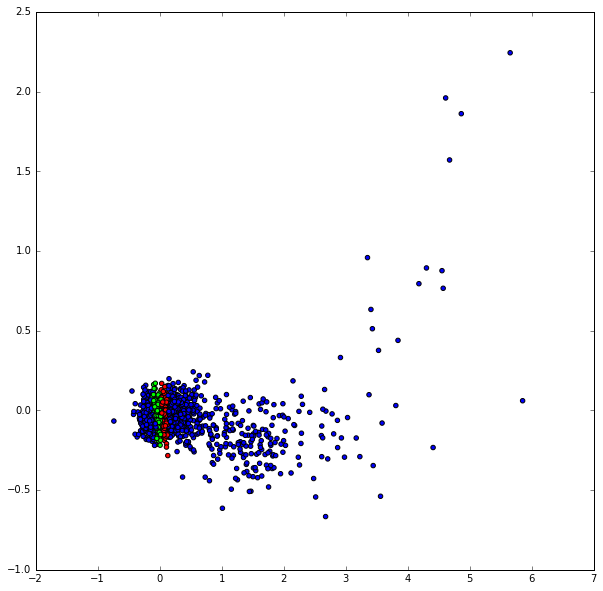

In [93]:
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
plt.figure(figsize=(10,10))
plt.scatter(doc_SVD[:, 0], doc_SVD[:,1], c=labels, cmap=cmap_bold)
plt.show()

In [99]:
def most_common(text_):
    X = vect.fit_transform(text_)
    freq = list(zip(vect.get_feature_names(), np.asarray(X.sum(axis=0)).ravel()))
    freq.sort(key=lambda a: a[1], reverse=True)
    return freq[:20]

In [103]:
vect = CountVectorizer(ngram_range = (1, 1), max_df = 200)
text_0 = []
text_1 = []
for i in range(len(text)):
    if labels[i] == 0:
        text_0.append(text[i])
    if labels[i] == 1:
        text_1.append(text[i])
most_common(text_0)    

[('pm', 595),
 ('secretary', 277),
 ('30', 245),
 ('are', 239),
 ('office', 239),
 ('from', 230),
 ('he', 225),
 ('re', 202),
 ('but', 200),
 ('your', 193),
 ('as', 187),
 ('see', 184),
 ('2010', 179),
 ('if', 177),
 ('2009', 176),
 ('so', 176),
 ('00', 175),
 ('10', 174),
 ('no', 172),
 ('what', 166)]

In [104]:
most_common(text_1)

[('pm', 308),
 ('he', 236),
 ('me', 213),
 ('but', 212),
 ('are', 210),
 ('so', 204),
 ('do', 202),
 ('if', 192),
 ('as', 185),
 ('your', 178),
 ('from', 173),
 ('office', 171),
 ('re', 171),
 ('secretary', 169),
 ('see', 168),
 ('about', 157),
 ('gov', 155),
 ('get', 151),
 ('what', 150),
 ('him', 147)]